In [1]:
!pip install squarify

In [2]:
!pip install StandarScaler

ERROR: Could not find a version that satisfies the requirement StandarScaler (from versions: none)
ERROR: No matching distribution found for StandarScaler


In [3]:
!pip install LogesticRegression

ERROR: Could not find a version that satisfies the requirement LogesticRegression (from versions: none)
ERROR: No matching distribution found for LogesticRegression


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn import preprocessing
import matplotlib.pyplot as plt
import squarify
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [5]:
heart = pd.read_csv(r"C:\Users\Dell\OneDrive - Hanoi University of Science and Technology\Desktop\heart.csv", index_col=None, na_values=['NaN'],)

In [6]:
heart['FastingBS'] = heart['FastingBS'].astype('object')

In [7]:
string_col = heart.select_dtypes(include="object").columns.tolist()

In [8]:
# There is one record with RestingBP = 0, which is impossible.
# We should change it to nan and then impute it later.
heart['RestingBP'] = heart['RestingBP'].replace(0, np.nan)

In [9]:
heart[heart['Cholesterol'] == 0].shape
# There are a lot of records with Cholesterol = 0, which is impossible too.
heart['Cholesterol'] = heart['Cholesterol'].replace(0, np.nan)

In [10]:
label_encoder = preprocessing.LabelEncoder()
heart['Sex'] = label_encoder.fit_transform(heart['Sex'])
heart['ExerciseAngina'] = label_encoder.fit_transform(heart['ExerciseAngina'])

In [11]:
# Convert ChestPainType to mean_encoding
df = pd.DataFrame(heart)
Mean_encoded = df.groupby(['ChestPainType'])['HeartDisease'].mean().to_dict()
df['ChestPainType'] =  df['ChestPainType'].map(Mean_encoded)

In [12]:
# Frequency encoding for RestingECG
count_encoded = df['RestingECG'].value_counts().to_dict()
df['RestingECG'] = df['RestingECG'].map(count_encoded)

In [13]:
# Ordinal encoding ST_Slope
ordinal_mapping = {
    'Up': 1,
    'Flat': 2,
    'Down': 3
}
df['ST_Slope'] = df['ST_Slope'].map(ordinal_mapping)

In [14]:
target = heart.iloc[:, -1]   # Last column as the target variable
feature = heart.iloc[:, :-1]  # All columns except the last one as the features

In [15]:
# KNN imputation for missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)
feature = imputer.fit_transform(feature)

In [16]:
#splitting the data into training and testing
feature_train, feature_test, target_train, target_test = train_test_split(feature, target, test_size=0.25, random_state=9)
print('Shape of feature and target respectively (train) :', feature_train.shape, target_train.shape)
print('Shape of feature and target respectively (test) :', feature_test.shape, target_test.shape)

Shape of feature and target respectively (train) : (688, 11) (688,)
Shape of feature and target respectively (test) : (230, 11) (230,)


In [17]:
# Building the Random Forest
model = RandomForestClassifier()
model.fit(feature_train, target_train)
result = model.score(feature_test, target_test)
print("Accuracy: %.3f%%" % (result*100.0))

Accuracy: 86.957%


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(feature_train, target_train)
print ("The best parameters")
print(rf_random.best_params_)

from sklearn import metrics
def evaluate(model, feature_test, target_test):
    predictions = model.predict(feature_test)
    accuracy = metrics.accuracy_score(target_test, predictions)
    print('Model Performance')
    print("Accuracy = {:0.2f}%".format(accuracy * 100))
    
    return accuracy

# Evaluate the Best Random Search Model
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, feature_test, target_test)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters
{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': True}
Model Performance
Accuracy = 87.39%


In [24]:
# Retrieve the cv_results_
cv_results = rf_random.cv_results_

# Sort the mean_test_score in descending order
sorted_indices = np.argsort(cv_results['mean_test_score'])[::-1]

# Retrieve the top 10 param_grid and mean_test_score
top_10_params = [cv_results['params'][index] for index in sorted_indices[:10]]
top_10_scores = [cv_results['mean_test_score'][index] for index in sorted_indices[:10]]

# Print the top 10 parameter combinations and their mean_test_scores
print("Top 10 parameter combinations:")
for params, score in zip(top_10_params, top_10_scores):
    print("params: ", params)
    print("mean_test_score: ", score)
    print()
    
bootstrap = set()
max_depth = set()
max_features = set()
min_samples_leaf = set()
min_samples_split = set()
n_estimators = set()

for i in range(0, 10):
    params = top_10_params[i]  # Get the i-th parameter combination
    bootstrap.add(params['bootstrap'])
    max_depth.add(params['max_depth'])
    max_features.add(params['max_features'])
    min_samples_leaf.add(params['min_samples_leaf'])
    min_samples_split.add(params['min_samples_split'])
    n_estimators.add(params['n_estimators'])

# Convert the sets to lists
bootstrap = list(bootstrap)
max_depth = list(max_depth)
max_features = list(max_features)
min_samples_leaf = list(min_samples_leaf)
min_samples_split = list(min_samples_split)
n_estimators = list(n_estimators)

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}
fr = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search.fit(feature_train, target_train)
print("The best parameter of GridSearchCV is: ")
print(grid_search.best_params_)

# Evaluate the Best Model from Grid Search
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, feature_test, target_test)

Top 10 parameter combinations:
params:  {'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': True}
mean_test_score:  -0.1293842161888488

params:  {'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': True}
mean_test_score:  -0.1308461489779128

params:  {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
mean_test_score:  -0.13229542434023164

params:  {'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': True}
mean_test_score:  -0.13229542434023164

params:  {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
mean_test_score:  -0.13230808176697675

params:  {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_lea

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
def cross_validation(model, feature_train, target_train, _cv = 10):
    a_scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator = model,
                           X = feature_train,
                           y = target_train,
                           cv = _cv,
                           scoring = a_scoring,
                           return_train_score = True)
    return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()}

best_params = grid_search.best_params_
best_model = RandomForestClassifier(
    bootstrap=best_params['bootstrap'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators']
)
randomForest_result = cross_validation(best_model, feature_train, target_train, 10) 


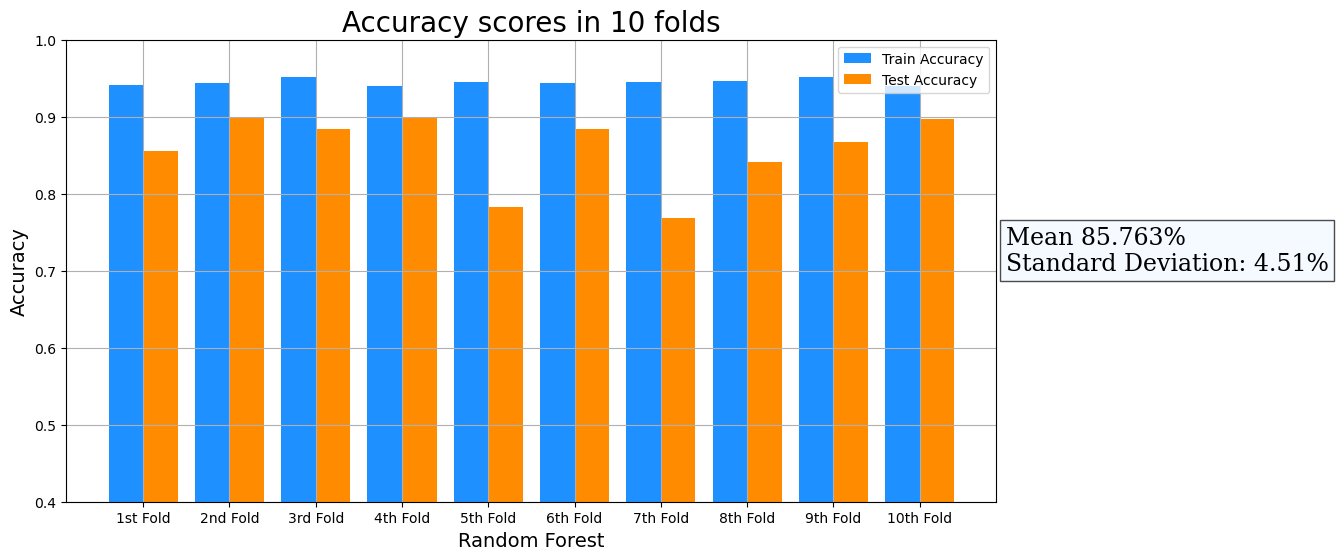

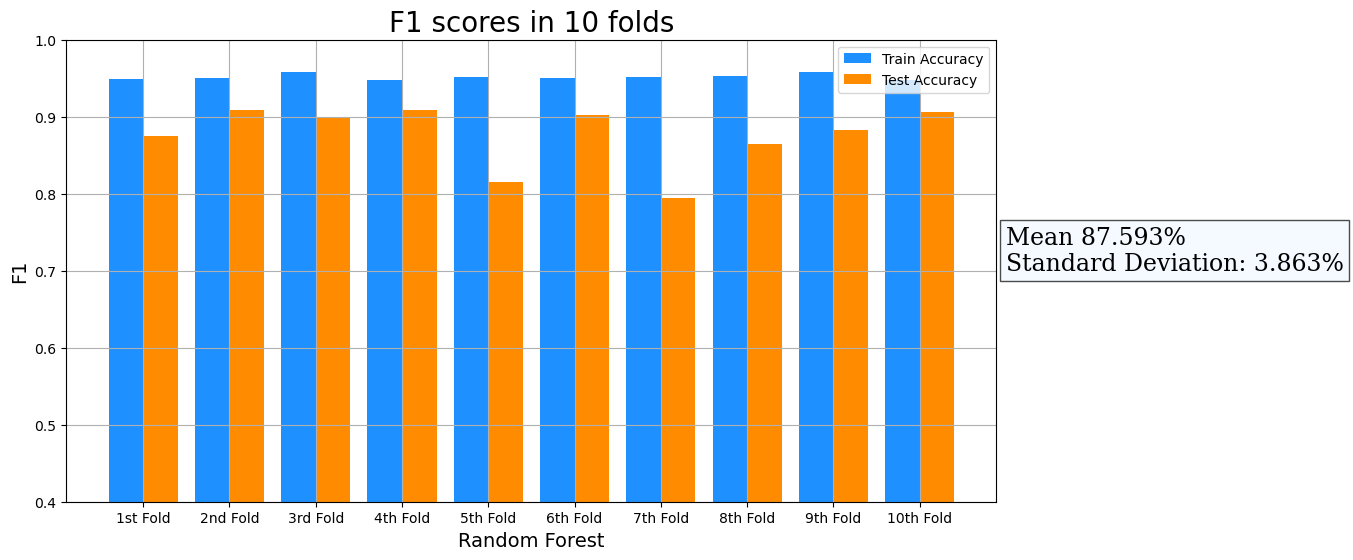

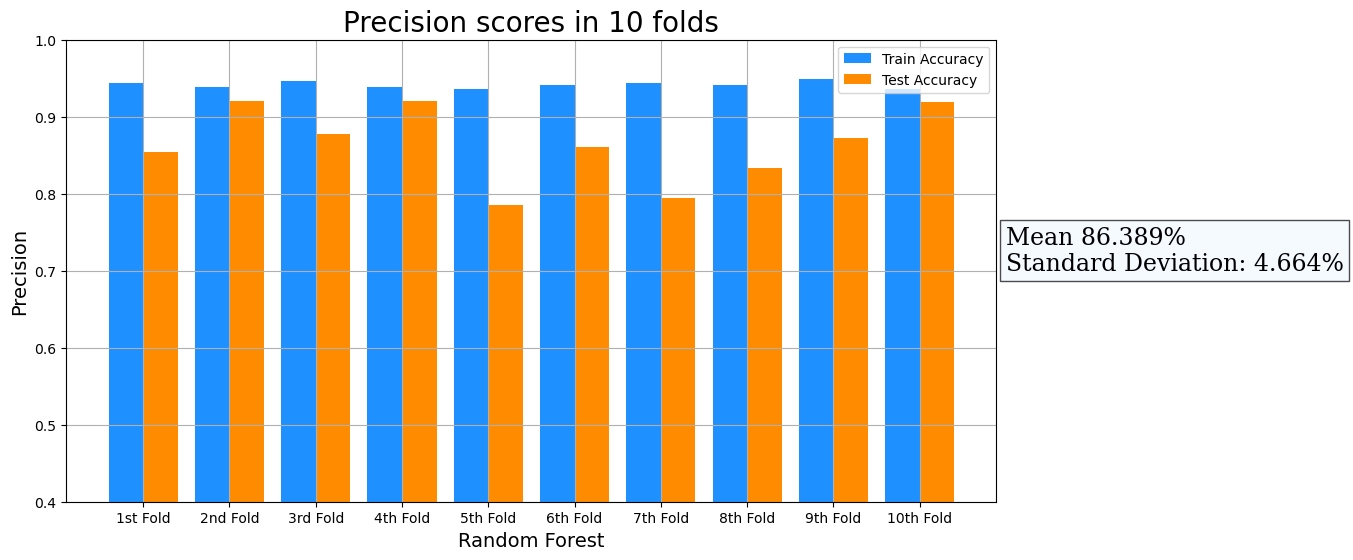

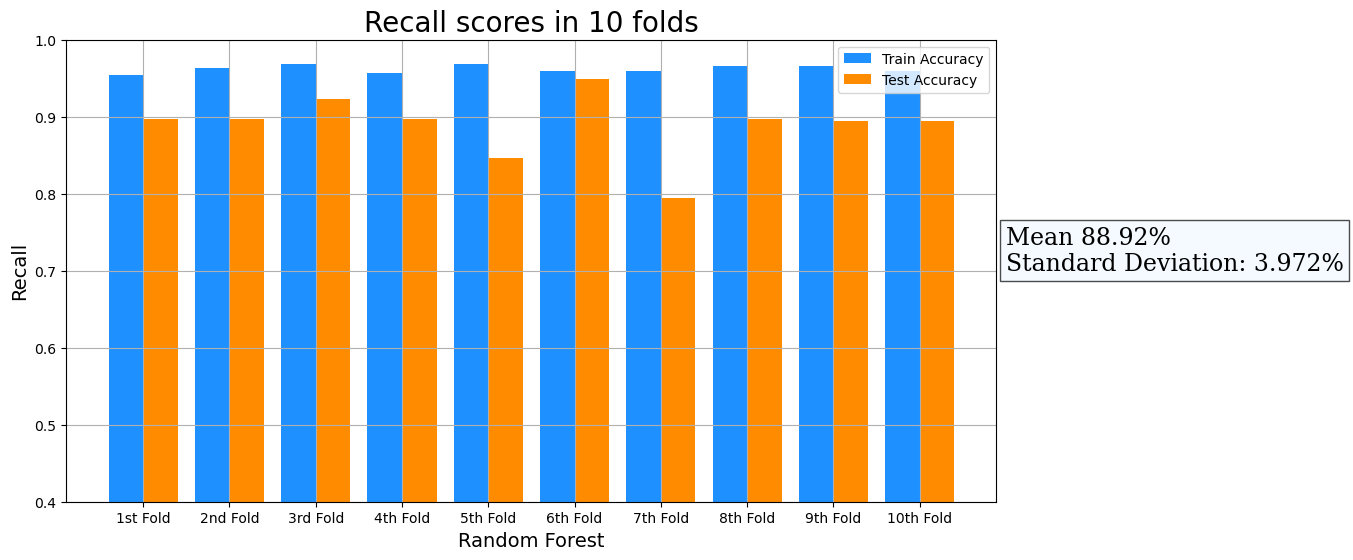

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_result(x_label, y_label, plot_title, train_data, val_data):
    # Set size of plot
    plt.figure(figsize=(12, 6))
    labels = ['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold', '6th Fold', '7th Fold', '8th Fold', '9th Fold', '10th Fold']
    X_axis = np.arange(len(labels))
    ax = plt.gca()
    plt.ylim(0.4, 1)
    plt.bar(X_axis - 0.2, train_data, 0.4, color='dodgerblue', label='Train Accuracy')
    plt.bar(X_axis + 0.2, val_data, 0.4, color='darkorange', label='Test Accuracy')
    plt.title(plot_title, fontsize=20)
    plt.xticks(X_axis, labels)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.text(10, 0.7, 'Mean ' + str(np.round(np.mean(val_data) * 100, 3)) + '%' + '\n' + 'Standard Deviation: ' + str(np.round(np.std(val_data) * 100, 3)) + '%', fontsize=17,
             fontfamily='serif', 
             bbox=dict(facecolor='aliceblue', alpha=0.7))
    plt.legend()
    plt.grid(True)
    plt.show()

model_name = "Random Forest"
model_name = "Random Forest"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 10 folds",
            randomForest_result["Training Accuracy scores"],randomForest_result["Validation Accuracy scores"])
plot_result(model_name,
            "F1",
            "F1 scores in 10 folds",
            randomForest_result["Training F1 scores"],
           randomForest_result["Validation F1 scores"])

plot_result(model_name,
            "Precision",
            "Precision scores in 10 folds",
            randomForest_result["Training Precision scores"],
           randomForest_result["Validation Precision scores"])
plot_result(model_name,
            "Recall",
            "Recall scores in 10 folds",
            randomForest_result["Training Recall scores"],
           randomForest_result["Validation Recall scores"])

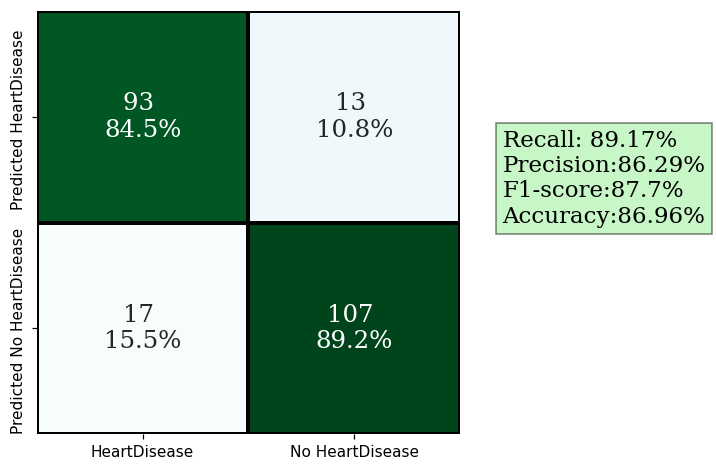

In [36]:
import seaborn as sns
#Predicting the model basead on the feature_test
y_actu1 = pd.DataFrame(target_test)
y_pred1 = model.predict(feature_test)
y_actu1=y_actu1['HeartDisease']

def plot_metrics(feature_train_1,target_train_1,classificador1):
    y_predict = classificador1.predict(feature_train_1)
    y_actu = target_train_1
 
    #--------- ROC Curve -------------------------------------------------------------------------------------------------------
    from sklearn.metrics import roc_curve
    y_pred_keras = classificador1.predict(feature_train_1).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve( y_actu, y_pred_keras)
    from sklearn.metrics import auc
    
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(figsize = (6,5),dpi=100)
    plt.plot([0.0,0.0,1.0], [0.0,1.0,1.0], label='Perfect Performance (AUC = 1.0)', ls=':', zorder=10, lw=1.0,c='Green')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    
    plt.plot(fpr_keras, tpr_keras, label='Classifier (area = {:.3f})'.format(auc_keras))
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show() 
    #-------------- Precision-Recall Curve -----------------------------------------------------------------------------------
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    plt.figure(figsize = (6,5),dpi=100)
    precision, recall, thresholds = precision_recall_curve(y_actu,y_predict)
    lr_precision, lr_recall, _ = precision_recall_curve(y_actu,y_predict)

    aucski = auc(recall, precision)
    no_skill = len(y_actu[y_actu==1]) / len(y_actu)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier (area = {:.2f})'.format(aucski))
    # axis labels
    plt.title('Precision x Recall curve')
    0
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
    #------------------------------------------------------------------------------
    
def matrix_confu(y_actua,y_preda):

    df_confusion = np.array(pd.crosstab(y_actua, y_preda))
    df_confusion_percent = np.zeros((2,2))
    df_confusion_percent[0,0]=df_confusion[0][0]/y_actua.value_counts()[0]
    df_confusion_percent[0,1]=df_confusion[0][1]/y_actua.value_counts()[0]
    df_confusion_percent[1,0]=df_confusion[1][0]/y_actua.value_counts()[1]
    df_confusion_percent[1,1]=df_confusion[1][1]/y_actua.value_counts()[1]
    x_axis_label=['HeartDisease','No HeartDisease',]
    y_axis_label=['Predicted HeartDisease ','Predicted No HeartDisease ']
    tn1 = round(np.float64((df_confusion[0][0]/(df_confusion[0][0]+df_confusion[0][1]))), 3)

    tp1 = round(np.float64((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[1][0])), 3)

    fn1 = round(np.float64(df_confusion[1][0]/(df_confusion[1][0]+df_confusion[1][1])), 3)

    fp1 = round(np.float64(df_confusion[0][1]/(df_confusion[0][1]+df_confusion[0][0])), 3)
       #----------------------------------------------------------------------------------------------------------------------
    
    acuracia = ((df_confusion[1][1]+df_confusion[0][0])/(df_confusion[1][1]+df_confusion[0][0]+df_confusion[1][0]+df_confusion[0][1]))*100
    precisao=float((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[0][1]))*100
    recall=float((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[1][0]))*100

    f1= 2*(precisao*recall)/(precisao+recall) 
   
    from sklearn.metrics import f1_score   

    porcentagens = [str(int(tn1*100000)/1000)+'%',str(int(fn1*100000)/1000)+'%',str(int(fp1*100000)/1000)+'%',str(int(tp1*100000)/1000)+'%']
    entradas = [int(df_confusion[0,0]),int(df_confusion[1,0]),int(df_confusion[0,1]),int(df_confusion[1,1])]
    labels = [f'{numero} \n{porc}' for numero, porc in zip(entradas,porcentagens)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (6,5),dpi=110)
    sns.heatmap(df_confusion_percent,square=True,
                 cmap="BuGn", annot=labels, cbar=False,fmt='',xticklabels=x_axis_label, yticklabels=y_axis_label,linewidths=1.6, linecolor='black', annot_kws={'fontsize':16,'fontfamily':'serif'})

    plt.text(2.2, 1, 'Recall: '+ str(np.round(recall,2))+'%'+'\n'+'Precision:'+ str(np.round(precisao,2))+'%'+'\n'+ 'F1-score:'+ str(np.round(f1,2))+'%'+'\n'+'Accuracy:'+str(np.round(acuracia,2))+'%', fontsize =15,
             fontfamily='serif', 
             bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
    plt.show()

matrix_confu(y_actu1,y_pred1)

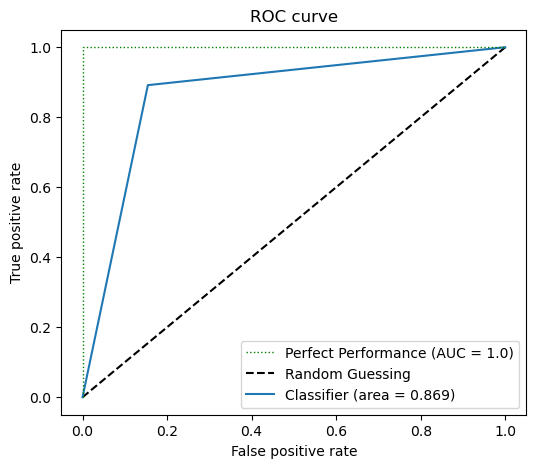

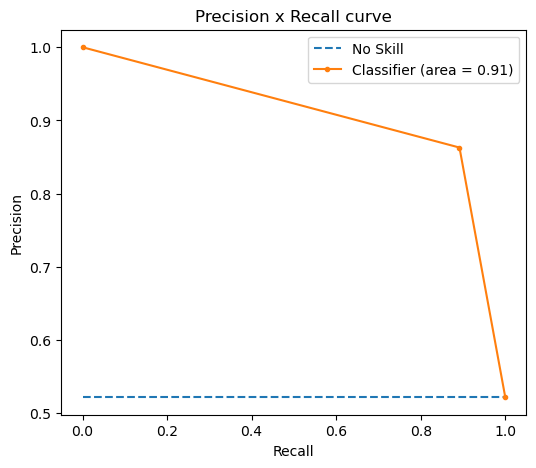

In [37]:
plot_metrics(feature_test,target_test,model)